## Homework 5 - Databases

Schema description:

table top airports:
aid primary key
icao secondary key
enplanements, ect
city secondary key

table airport info:
icao main key
long
lat
elevation
/////

table weather info:
wid primary key unique ect
city string
date Date
min temp Float
max temp
humid
precip


one city might apply to several airports

table airports:
aid primary key 
icao
city


QS: do I need a relationship?

In [248]:
import pandas as pd
from sqlalchemy import *#Table, MetaData, create_engine
from bs4 import BeautifulSoup
import requests


In [249]:
top_airports_filename = "hw_5/hw_5_data/top_airports.csv"
airport_info_filename = "hw_5/hw_5_data/ICAO_airports.csv"

top_airports = pd.read_csv(top_airports_filename)
airport_info = pd.read_csv(airport_info_filename)

In [250]:
#homework suggests a single table for airports, so use pandas to merge these two tables
mrgd = top_airports.merge(airport_info, how='left',left_on = 'ICAO', right_on = 'ident')
#fix any nulls
mrgd = mrgd.where(pd.notnull(mrgd), None)

In [251]:
engine = create_engine('sqlite:///hw_5/initial2.db')
metadata = MetaData()

In [252]:
#create my table classes
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import relationship
Base = declarative_base()
        
class Airport(Base):
    __tablename__ = 'airports'
    id = Column(Integer, primary_key=True)
    ICAO = Column(String)
    city = Column(String)
    iso_region = Column(String)
    enplanements = Column(Integer)
    elevation_ft = Column(Float)
    latitude_deg = Column(Float)
    longitude_deg = Column(Float)
    weathers = relationship('AirportWeather', backref = 'Airport')
    
class AirportWeather(Base):
    __tablename__ = 'weathers'
    id = Column(Integer, primary_key=True)
    day = Column(Date)
    high = Column(Float)
    low = Column(Float)
    humidity = Column(Float)
    precipitation = Column(Float)
    events = Column(String)
    aid = Column(Integer, ForeignKey('airports.id'))


In [253]:
Base.metadata.create_all(engine) 

from sqlalchemy.orm import sessionmaker
Session = sessionmaker(bind=engine)
session = Session()
def is_td_has_no_class(tag):
    return tag.name =='td' and not tag.has_attr('class')


In [254]:
#so then populate an airport table
for i,row in mrgd.iterrows():
    a = Airport(city = row.City, ICAO=row.ICAO, iso_region = row.iso_region, enplanements = row.Enplanements,
                elevation_ft = row.elevation_ft,
               longitude_deg = row.longitude_deg, latitude_deg = row.latitude_deg)
    session.add(a)

In [256]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for a in session.query(Airport)[20:40]:
    ICAO = a.ICAO
    curr_year = 2008
    for yr in range(0,11):
        if curr_year == 2018:
            weather_req = requests.get(
                "https://www.wunderground.com/history/airport/" + ICAO + \
                '/' +str(curr_year)+ '/1/1/CustomHistory.html?dayend=6&monthend=3&yearend='+str(curr_year))
        else:
            weather_req = requests.get(
                "https://www.wunderground.com/history/airport/" + ICAO + \
                '/' +str(curr_year)+ '/1/1/CustomHistory.html?dayend=31&monthend=12&yearend='+str(curr_year))
        soup = BeautifulSoup(weather_req.text,"html.parser")
        print(curr_year)
        table_entries=soup.find('table', id = 'obsTable').find_all(is_td_has_no_class)
        table_entries_str = [str(entry.text) if len(entry.contents)==1 else str(entry.contents[1].text) for entry in table_entries]

    
        curr_month = 0
        curr_ind = 0
        ncols = 21
        if curr_year == 2018:
            dayrange = 31+28+6
        elif curr_year in [2008,2012, 2016]:
            dayrange = 366
        else:
            dayrange = 365
        for _ in range(0,dayrange):
            #first check if theres a month indicator
            if table_entries_str[curr_ind] in months:
                curr_month += 1
                curr_ind += 1

            row = table_entries_str[curr_ind:curr_ind+ncols]
            if '\t' in row[20]:
                row[20] = ''
            else:
                row[20] = row[20].replace('\n','')

            curr_ind += ncols
            dateday = datetime.date(int(curr_year), curr_month, int(row[0]))
            
            #sometimes the precipitation is just T? so handle that I guess
            if row[19]=='T':
                row[19]=None
                
            for i,s in enumerate(row):
                if s is not None:
                    if '-' in s:
                        row[i]=None
            aw=AirportWeather(day = dateday, high = row[1], low = row[3], humidity = row[8],
                              precipitation =  row[19], events = row[20], aid = a.id)
            session.add(aw)
            
        curr_year += 1

2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2008
2009


In [ ]:
#do pairwise correlations somehow
correlations = np.empty((2,2,50,50))
for a in session.query(Airport):
    for idy in range(a.id+1, session.query(Airport).all()[len(session.query(Airport).all())-1].id):
        things = [aw.high for aw in session.query(AirportWeather).filter(AirportWeather.aid==a.id).all()]
        things2 = [aw.high for aw in session.query(AirportWeather).filter(AirportWeather.aid==idy).all()]
        x = pd.Series(things[0:3718-3])
        y = pd.Series(things2[3:3718])
        x.fillna(method='bfill', inplace=True)
        y.fillna(method='bfill', inplace=True)
        y.astype('float64', inplace=True)
        x2 = x.values
        y2 = y.values
        y2 = y2.astype('float64')
        print(type(x.values))
        print(type(y[1]))
        print(type(x[1]))
        print(np.corrcoef(x2,y2))
        correlations(:,:,a.id, idy) = np.corrcoef()

In [230]:
session.query(Airport).all()[len(session.query(Airport).all())-1].id

50

<class 'numpy.ndarray'>
<class 'float'>
<class 'numpy.float64'>
(2, 2)


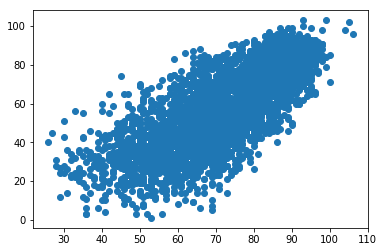

In [231]:
import numpy as np

things = [aw.high for aw in session.query(AirportWeather).filter(AirportWeather.aid==1).all()]
things2 = [aw.high for aw in session.query(AirportWeather).filter(AirportWeather.aid==2).all()]
x = pd.Series(things[0:3718-3])
y = pd.Series(things2[3:3718])
x.fillna(method='bfill', inplace=True)
y.fillna(method='bfill', inplace=True)
y.astype('float64', inplace=True)
x2 = x.values
y2 = y.values
y2 = y2.astype('float64')
print(type(x.values))
print(type(y[1]))
print(type(x[1]))
print(np.corrcoef(x2,y2))
import matplotlib.pyplot as plt
plt.scatter(x2,y2)

In [197]:
[print(aw.day) for aw in session.query(AirportWeather).all()]
print(len(session.query(AirportWeather).all()))

2008-01-01
2008-01-02
2008-01-03
2008-01-04
2008-01-05
2008-01-06
2008-01-07
2008-01-08
2008-01-09
2008-01-10
2008-01-11
2008-01-12
2008-01-13
2008-01-14
2008-01-15
2008-01-16
2008-01-17
2008-01-18
2008-01-19
2008-01-20
2008-01-21
2008-01-22
2008-01-23
2008-01-24
2008-01-25
2008-01-26
2008-01-27
2008-01-28
2008-01-29
2008-01-30
2008-01-31
2008-02-01
2008-02-02
2008-02-03
2008-02-04
2008-02-05
2008-02-06
2008-02-07
2008-02-08
2008-02-09
2008-02-10
2008-02-11
2008-02-12
2008-02-13
2008-02-14
2008-02-15
2008-02-16
2008-02-17
2008-02-18
2008-02-19
2008-02-20
2008-02-21
2008-02-22
2008-02-23
2008-02-24
2008-02-25
2008-02-26
2008-02-27
2008-02-28
2008-02-29
2008-03-01
2008-03-02
2008-03-03
2008-03-04
2008-03-05
2008-03-06
2008-03-07
2008-03-08
2008-03-09
2008-03-10
2008-03-11
2008-03-12
2008-03-13
2008-03-14
2008-03-15
2008-03-16
2008-03-17
2008-03-18
2008-03-19
2008-03-20
2008-03-21
2008-03-22
2008-03-23
2008-03-24
2008-03-25
2008-03-26
2008-03-27
2008-03-28
2008-03-29
2008-03-30
2008-03-31

2015-04-13
2015-04-14
2015-04-15
2015-04-16
2015-04-17
2015-04-18
2015-04-19
2015-04-20
2015-04-21
2015-04-22
2015-04-23
2015-04-24
2015-04-25
2015-04-26
2015-04-27
2015-04-28
2015-04-29
2015-04-30
2015-05-01
2015-05-02
2015-05-03
2015-05-04
2015-05-05
2015-05-06
2015-05-07
2015-05-08
2015-05-09
2015-05-10
2015-05-11
2015-05-12
2015-05-13
2015-05-14
2015-05-15
2015-05-16
2015-05-17
2015-05-18
2015-05-19
2015-05-20
2015-05-21
2015-05-22
2015-05-23
2015-05-24
2015-05-25
2015-05-26
2015-05-27
2015-05-28
2015-05-29
2015-05-30
2015-05-31
2015-06-01
2015-06-02
2015-06-03
2015-06-04
2015-06-05
2015-06-06
2015-06-07
2015-06-08
2015-06-09
2015-06-10
2015-06-11
2015-06-12
2015-06-13
2015-06-14
2015-06-15
2015-06-16
2015-06-17
2015-06-18
2015-06-19
2015-06-20
2015-06-21
2015-06-22
2015-06-23
2015-06-24
2015-06-25
2015-06-26
2015-06-27
2015-06-28
2015-06-29
2015-06-30
2015-07-01
2015-07-02
2015-07-03
2015-07-04
2015-07-05
2015-07-06
2015-07-07
2015-07-08
2015-07-09
2015-07-10
2015-07-11
2015-07-12

2010-07-29
2010-07-30
2010-07-31
2010-08-01
2010-08-02
2010-08-03
2010-08-04
2010-08-05
2010-08-06
2010-08-07
2010-08-08
2010-08-09
2010-08-10
2010-08-11
2010-08-12
2010-08-13
2010-08-14
2010-08-15
2010-08-16
2010-08-17
2010-08-18
2010-08-19
2010-08-20
2010-08-21
2010-08-22
2010-08-23
2010-08-24
2010-08-25
2010-08-26
2010-08-27
2010-08-28
2010-08-29
2010-08-30
2010-08-31
2010-09-01
2010-09-02
2010-09-03
2010-09-04
2010-09-05
2010-09-06
2010-09-07
2010-09-08
2010-09-09
2010-09-10
2010-09-11
2010-09-12
2010-09-13
2010-09-14
2010-09-15
2010-09-16
2010-09-17
2010-09-18
2010-09-19
2010-09-20
2010-09-21
2010-09-22
2010-09-23
2010-09-24
2010-09-25
2010-09-26
2010-09-27
2010-09-28
2010-09-29
2010-09-30
2010-10-01
2010-10-02
2010-10-03
2010-10-04
2010-10-05
2010-10-06
2010-10-07
2010-10-08
2010-10-09
2010-10-10
2010-10-11
2010-10-12
2010-10-13
2010-10-14
2010-10-15
2010-10-16
2010-10-17
2010-10-18
2010-10-19
2010-10-20
2010-10-21
2010-10-22
2010-10-23
2010-10-24
2010-10-25
2010-10-26
2010-10-27

2017-06-02
2017-06-03
2017-06-04
2017-06-05
2017-06-06
2017-06-07
2017-06-08
2017-06-09
2017-06-10
2017-06-11
2017-06-12
2017-06-13
2017-06-14
2017-06-15
2017-06-16
2017-06-17
2017-06-18
2017-06-19
2017-06-20
2017-06-21
2017-06-22
2017-06-23
2017-06-24
2017-06-25
2017-06-26
2017-06-27
2017-06-28
2017-06-29
2017-06-30
2017-07-01
2017-07-02
2017-07-03
2017-07-04
2017-07-05
2017-07-06
2017-07-07
2017-07-08
2017-07-09
2017-07-10
2017-07-11
2017-07-12
2017-07-13
2017-07-14
2017-07-15
2017-07-16
2017-07-17
2017-07-18
2017-07-19
2017-07-20
2017-07-21
2017-07-22
2017-07-23
2017-07-24
2017-07-25
2017-07-26
2017-07-27
2017-07-28
2017-07-29
2017-07-30
2017-07-31
2017-08-01
2017-08-02
2017-08-03
2017-08-04
2017-08-05
2017-08-06
2017-08-07
2017-08-08
2017-08-09
2017-08-10
2017-08-11
2017-08-12
2017-08-13
2017-08-14
2017-08-15
2017-08-16
2017-08-17
2017-08-18
2017-08-19
2017-08-20
2017-08-21
2017-08-22
2017-08-23
2017-08-24
2017-08-25
2017-08-26
2017-08-27
2017-08-28
2017-08-29
2017-08-30
2017-08-31